In [447]:
from cpymad.madx import Madx
import numpy as np
import matplotlib.pyplot as plt
from madxtools.particles import *
import sys
import os
current_working_directory = os.getcwd()
module_directory = os.path.join(current_working_directory, '..')
absolute_module_directory = os.path.abspath(module_directory)
sys.path.append(absolute_module_directory)
from t07_functions import *

In [512]:
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("simple_seq.seq")

p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)


madx.command.beam(particle='PROTON',pc=p,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')



madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence="simple_seq")

madx.use(sequence="simple_seq")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c


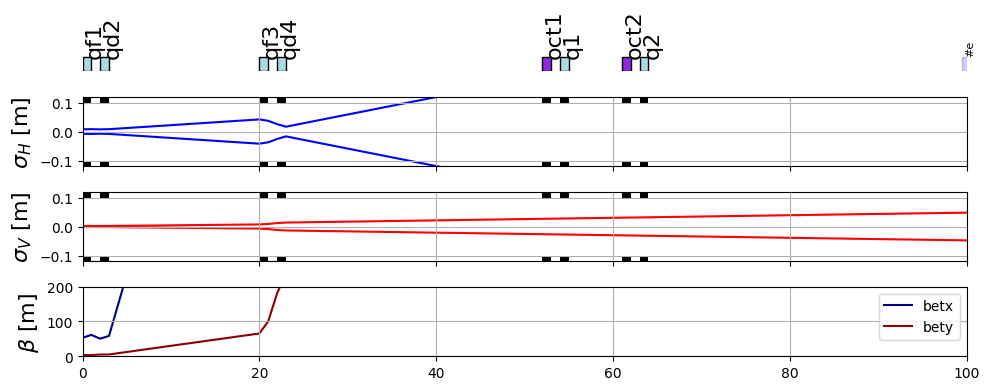

In [449]:
plot_graph(twiss, ex, sige, ey)

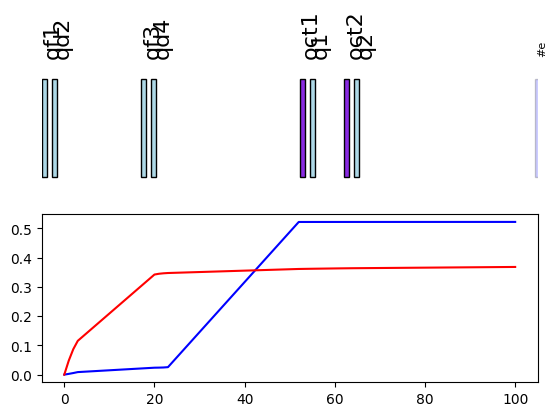

In [450]:
fig, ax = plt.subplots(2,1)

madx.input("kQD2 = -0.25;")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
draw_synoptic(ax[0],twiss)
ax[1].plot(twiss.s, twiss.mux, c="b")
ax[1].plot(twiss.s, twiss.muy, c="r")

In [594]:
import scipy.optimize as optimize
import pybobyqa

fetch_rows = lambda indices, attribute: np.array([getattr(twiss.row(index), attribute) for index in indices])


def optimise(params):

    kQF1, kQD2, kQF3, kQD4, kQ1, kQ2, oct1_pos, oct2_pos = params
    print(params)

    madx.input(f"kQF1 = {kQF1};")
    madx.input(f"kQD2 = {kQD2};")
    madx.input(f"kQF3 = {kQF3};")
    madx.input(f"kQD4 = {kQD4};")

    madx.input(f"kQ1 = {kQ1};")
    madx.input(f"kQ2 = {kQ2};")

    madx.input('SEQEDIT, sequence=simple_seq;')
    madx.input(f'MOVE, ELEMENT = OCT1, TO={oct1_pos};')
    madx.input('MOVE, ELEMENT = Q1, TO=1, FROM=OCT1;')
    madx.input(f'MOVE, ELEMENT = OCT2, TO={oct2_pos};')
    madx.input('MOVE, ELEMENT = Q2, TO=1, FROM=OCT2;')
    madx.input('ENDEDIT;')

    madx.use(sequence="simple_seq")
    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)

    mux_o1 = twiss.row(twiss.row_names().index('oct1')).mux
    muy_o1 = twiss.row(twiss.row_names().index('oct1')).muy

    mux_o2 = twiss.row(twiss.row_names().index('oct2')).mux
    muy_o2 = twiss.row(twiss.row_names().index('oct2')).muy

    weight_phase_adv = 0.1
    targets = [0.25, 0.75]
    normalized_phase_diff = np.abs(mux_o1-muy_o1)
    closest_target = min(targets, key=lambda x: min(np.abs(normalized_phase_diff - x), np.abs(normalized_phase_diff - (x-1))))
    phase_advance_objective_o1 = np.abs(closest_target - normalized_phase_diff)
    phase_advance_objective_o1 = np.abs(phase_advance_objective_o1 - int(phase_advance_objective_o1))

    normalized_phase_diff = np.abs(mux_o2-muy_o2)
    closest_target = min(targets, key=lambda x: min(np.abs(normalized_phase_diff - x), np.abs(normalized_phase_diff - (x-1))))
    phase_advance_objective_o2 = np.abs(closest_target - normalized_phase_diff)
    phase_advance_objective_o2 = np.abs(phase_advance_objective_o2 - int(phase_advance_objective_o2))
    
    phase_advance_objective = weight_phase_adv*(phase_advance_objective_o1 + phase_advance_objective_o2)

    weight_small = 1
    location = "oct1"
    objective_beam_size_o1_x = np.abs(beam_size(twiss.row(twiss.row_names().index(location)).betx, twiss.row(twiss.row_names().index(location)).dx, ex, sige, 1))
    target_beam_size_o1 = 0.1
    objective_beam_size_o1_y = np.abs(target_beam_size_o1 - np.abs(beam_size(twiss.row(twiss.row_names().index(location)).bety, twiss.row(twiss.row_names().index(location)).dy, ey, sige, 1)))
    objective_beam_size_o1 = objective_beam_size_o1_x*weight_small + objective_beam_size_o1_y
    
    location = "oct2"
    objective_beam_size_o2_y = np.abs(beam_size(twiss.row(twiss.row_names().index(location)).bety, twiss.row(twiss.row_names().index(location)).dy, ey, sige, 1))
    target_beam_size_o2 = 0.1
    objective_beam_size_o2_x = np.abs(target_beam_size_o2 - np.abs(beam_size(twiss.row(twiss.row_names().index(location)).betx, twiss.row(twiss.row_names().index(location)).dx, ex, sige, 1)))
    objective_beam_size_o2 = objective_beam_size_o2_x + objective_beam_size_o2_y*weight_small

    weight_end = 1/1000
    location = "#e"
    target_beam_size_end = 0.03
    objective_beam_size_end_x = np.abs(target_beam_size_end - np.abs(beam_size(twiss.row(twiss.row_names().index(location)).betx, twiss.row(twiss.row_names().index(location)).dx, ex, sige, 1)))
    objective_beam_size_end_y = np.abs(target_beam_size_end - np.abs(beam_size(twiss.row(twiss.row_names().index(location)).bety, twiss.row(twiss.row_names().index(location)).dy, ey, sige, 1)))
    objective_beam_size_end = (objective_beam_size_end_x + objective_beam_size_end_y)*weight_end
    
    objective_beam_size = objective_beam_size_o1 + objective_beam_size_o2 + objective_beam_size_end

    fetch_rows = lambda indices, attribute: np.array([getattr(twiss.row(index), attribute) for index in indices])
    penality = 0
    penality_weigth = 1e2
    for aper_1, betx, dx in zip(fetch_rows(np.where(twiss.aper_1 != 0)[0], 'aper_1'),
                                fetch_rows(np.where(twiss.aper_1 != 0)[0], 'betx'),
                                fetch_rows(np.where(twiss.aper_1 != 0)[0], 'dx')):
        beam_size_x = beam_size(betx, dx, ex, sige, 1)
        exceedance_x = beam_size_x - aper_1
        if exceedance_x > 0:
            penality += exceedance_x * penality_weigth
    for aper_1, bety, dy in zip(fetch_rows(np.where(twiss.aper_1 != 0)[0], 'aper_1'),
                                fetch_rows(np.where(twiss.aper_1 != 0)[0], 'bety'),
                                fetch_rows(np.where(twiss.aper_1 != 0)[0], 'dy')):
        beam_size_y = beam_size(bety, dy, ey, sige, 1)
        exceedance_y = beam_size_y - aper_1
        if exceedance_y > 0:
            penality += exceedance_y * penality_weigth 

    objective =  objective_beam_size + penality + phase_advance_objective
    
    print (f"OJECTIVE = {objective}")
    return objective

initial_guess = np.array([ 4.67857526e-01, -3.39864937e-01,  4.00070676e-02,  3.30898395e-01,
       -1.43411526e-01,  4.60983083e-02,  2.59696089e+01,  6.00317217e+01])

lower = np.array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 25, 60])
upper = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 55, 90])

soln = pybobyqa.solve(optimise, initial_guess, bounds=(lower,upper), rhobeg = 0.5, rhoend=0.0001, scaling_within_bounds=True, seek_global_minimum=True, objfun_has_noise=False, maxfun=20000)
print(soln)

[ 4.67857526e-01 -3.39864937e-01  4.00070676e-02  3.30898395e-01
 -1.43411526e-01  4.60983083e-02  2.59696089e+01  6.00317217e+01]
OJECTIVE = 0.11586692075548492
[ 5.00000000e-01 -3.39864937e-01  4.00070676e-02  3.30898395e-01
 -1.43411526e-01  4.60983083e-02  2.59696089e+01  6.00317217e+01]
OJECTIVE = 0.15873312565228725
[ 4.67857526e-01  1.60135063e-01  4.00070676e-02  3.30898395e-01
 -1.43411526e-01  4.60983083e-02  2.59696089e+01  6.00317217e+01]
OJECTIVE = 98.35873008558549
[ 4.67857526e-01 -3.39864937e-01  5.00000000e-01  3.30898395e-01
 -1.43411526e-01  4.60983083e-02  2.59696089e+01  6.00317217e+01]
OJECTIVE = 16.44256266381179
[ 4.67857526e-01 -3.39864937e-01  4.00070676e-02  5.00000000e-01
 -1.43411526e-01  4.60983083e-02  2.59696089e+01  6.00317217e+01]
OJECTIVE = 9.504507348110797
[ 4.67857526e-01 -3.39864937e-01  4.00070676e-02  3.30898395e-01
  3.56588474e-01  4.60983083e-02  2.59696089e+01  6.00317217e+01]
OJECTIVE = 64.05799351652867
[ 4.67857526e-01 -3.39864937e-01  4.

In [595]:
soln.x

array([ 0.31554861,  0.14617272, -0.37029875,  0.3055347 , -0.32936037,
        0.1219292 , 54.99999213, 60.08033072])

0.3214430163123938
0.17769649141355826


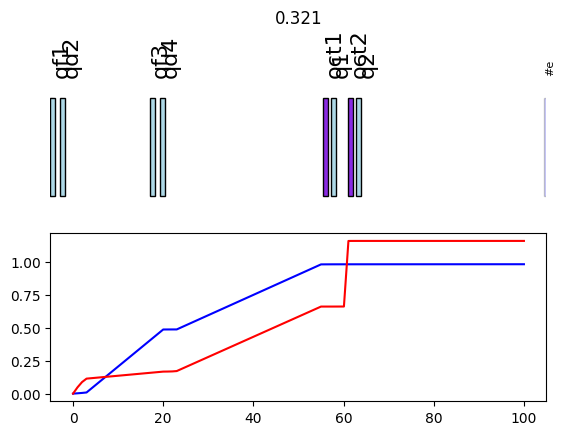

In [596]:
fig, ax = plt.subplots(2,1)
madx.input(f"kQF1 = {soln.x[0]};")
madx.input(f"kQD2 = {soln.x[1]};")
madx.input(f"kQF3 = {soln.x[2]};")
madx.input(f"kQD4 = {soln.x[3]};")
madx.input(f"kQ1 = {soln.x[4]};")
madx.input(f"kQ2 = {soln.x[5]};")

madx.input('SEQEDIT, sequence=simple_seq;')
madx.input(f'MOVE, ELEMENT = OCT1, TO={soln.x[6]};')
madx.input('MOVE, ELEMENT = Q1, TO=1, FROM=OCT1;')
madx.input(f'MOVE, ELEMENT = OCT2, TO={soln.x[7]};')
madx.input('MOVE, ELEMENT = Q2, TO=1, FROM=OCT2;')
madx.input('ENDEDIT;')

madx.use(sequence="simple_seq")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
draw_synoptic(ax[0],twiss)
ax[1].plot(twiss.s, twiss.mux, c="b")
ax[1].plot(twiss.s, twiss.muy, c="r")

mux_o1 = twiss.loc["oct1"].mux
muy_o1 = twiss.loc["oct1"].muy
ax[0].set_title(f"{np.abs(mux_o1-muy_o1):.3f}")

twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
mux_o1 = twiss.row(twiss.row_names().index('oct1')).mux
muy_o1 = twiss.row(twiss.row_names().index('oct1')).muy

mux_o2 = twiss.row(twiss.row_names().index('oct2')).mux
muy_o2 = twiss.row(twiss.row_names().index('oct2')).muy

weight_phase_adv = 0.01
target_phase_diff = 0.5
phase_advance_objective_o1 = np.abs(target_phase_diff - np.abs(mux_o1-muy_o1))
phase_advance_objective_o1 = np.abs(phase_advance_objective_o1 - int(phase_advance_objective_o1)) # Only take the decimal
phase_advance_objective_o2 = np.abs(target_phase_diff - np.abs(mux_o2-muy_o2))
phase_advance_objective_o2 = np.abs(phase_advance_objective_o2 - int(phase_advance_objective_o2))
phase_advance_objective = weight_phase_adv*(phase_advance_objective_o1 + phase_advance_objective_o2)

print(np.abs(mux_o1-muy_o1))
print(np.abs(mux_o2-muy_o2))

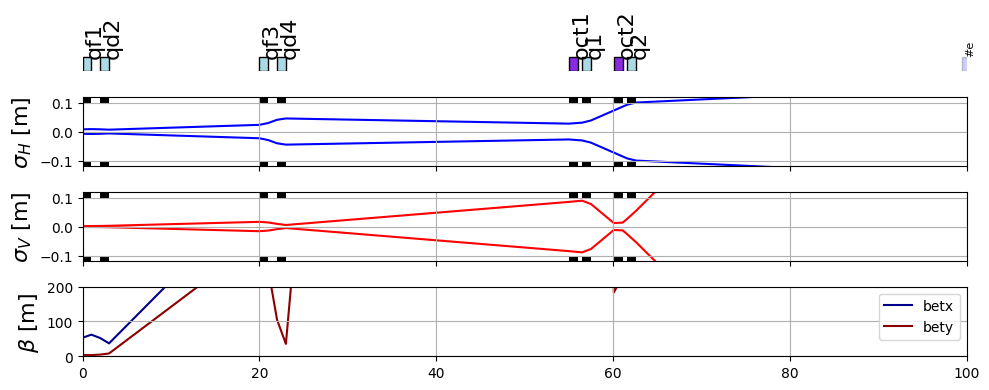

In [597]:
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
plot_graph(twiss, ex, sige, ey)

In [598]:
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
fetch_rows = lambda indices, attribute: np.array([getattr(twiss.row(index), attribute) for index in indices])
penality = 0
if ( any(val < 0 for val in fetch_rows(np.where(twiss.aper_1 != 0)[0], 'aper_1') - beam_size(fetch_rows(np.where(twiss.aper_1 != 0)[0], 'betx'), fetch_rows(np.where(twiss.aper_1 != 0)[0], 'dx'), ex, sige, 1)) == True): # Only do the check were you have aperture data
    penality = 1e2
if ( any(val < 0 for val in fetch_rows(np.where(twiss.aper_1 != 0)[0], 'aper_1') - beam_size(fetch_rows(np.where(twiss.aper_1 != 0)[0], 'bety'), fetch_rows(np.where(twiss.aper_1 != 0)[0], 'dy'), ey, sige, 1)) == True):
    penality = 1e2

In [599]:
for aper_1, betx, dx in zip(fetch_rows(np.where(twiss.aper_1 != 0)[0], 'aper_1'),
                            fetch_rows(np.where(twiss.aper_1 != 0)[0], 'betx'),
                            fetch_rows(np.where(twiss.aper_1 != 0)[0], 'dx')):
    beam_size_x = beam_size(betx, dx, ex, sige, 1)
    exceedance_x = beam_size_x - aper_1
    if exceedance_x > 0:
        penality += exceedance_x * 1e2  # Adjust the factor as necessary
print(penality)

0
